# 🔋 Analisis Kapasitas, Efisiensi, dan True OCV
**Tujuan:** 1. Menghitung Kapasitas Aktual ($Q_{25}$) dan Coulombic Efficiency ($\eta$) dari pengujian 3 Siklus Kontinu.
2. Mengekstrak kurva **True Open-Circuit Voltage (OCV)** menggunakan algoritma *Voltage Drop Blending* (Metode Coursera) yang disyaratkan untuk pemodelan EKF.

**Dataset:** Data pengujian 3 Loop Charge-Discharge (`charge-discharge 3x.csv`). Fase inisialisasi awal (Step 1-1) diabaikan karena baterai belum dalam kondisi *full cycle*.

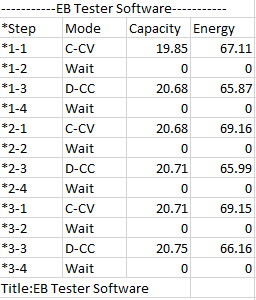

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Konfigurasi Tampilan
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Load Data
filename = "charge-discharge 3x.csv"

# 1. Baca Header (Summary)
steps_summary = []
skip_rows = 0
with open(filename, 'r', encoding='utf-8') as f:
    for i, line in enumerate(f):
        if line.startswith('*') and 'Step' not in line:
            parts = line.strip().split(',')
            try:
                steps_summary.append({
                    'Step': parts[0].replace('*', ''),
                    'Mode': parts[1],
                    'Capacity(Ah)': float(parts[2]),
                    'Energy(Wh)': float(parts[3])
                })
            except ValueError:
                pass
        if "Time(S)" in line:
            skip_rows = i
            break

df_steps = pd.DataFrame(steps_summary)

# 2. Baca Data Time Series
df_raw = pd.read_csv(filename, skiprows=skip_rows)
df_raw.columns = [c.strip() for c in df_raw.columns]

print("✅ Data berhasil dimuat!")
display(df_steps)

✅ Data berhasil dimuat!


,Step,Mode,Capacity(Ah),Energy(Wh)
0,1-1,C-CV,19.85,67.11
1,1-2,Wait,0.00,0.00
2,1-3,D-CC,20.68,65.87
3,1-4,Wait,0.00,0.00
4,2-1,C-CV,20.68,69.16
5,2-2,Wait,0.00,0.00
6,2-3,D-CC,20.71,65.99
7,2-4,Wait,0.00,0.00
8,3-1,C-CV,20.71,69.15
9,3-2,Wait,0.00,0.00


### 1. Perhitungan Kapasitas & Efisiensi Coulombic ($\eta$)
Kita mengambil pasangan siklus yang sudah stabil (Siklus 2 dan Siklus 3), mengabaikan Step 1-1.

In [2]:
# Ekstrak data Discharge dan Charge yang stabil
# D-CC (Discharge) -> 1-3, 2-3, 3-3
dis_caps = df_steps[df_steps['Mode'] == 'D-CC']['Capacity(Ah)'].values
# C-CV (Charge) -> 2-1, 3-1 (Abaikan 1-1)
chg_caps = df_steps[(df_steps['Mode'] == 'C-CV') & (df_steps['Step'] != '1-1')]['Capacity(Ah)'].values

# Hitung Rata-rata Kapasitas Discharge (Q25)
Q25_actual = np.mean(dis_caps)

# Hitung Efisiensi (Membandingkan Discharge vs Charge pada siklus yang sama)
# Siklus 2: Discharge 1-3 (20.68) dipakai lalu di-Charge 2-1 (20.68)
# Siklus 3: Discharge 2-3 (20.71) dipakai lalu di-Charge 3-1 (20.71)
eta_list = []
for i in range(min(len(dis_caps), len(chg_caps))):
    eta = dis_caps[i] / chg_caps[i]
    eta_list.append(eta)

eta_avg = np.mean(eta_list)

print("="*40)
print(f"📊 HASIL ANALISIS KAPASITAS & EFISIENSI")
print("="*40)
print(f"Total Kapasitas Aktual (Q25) : {Q25_actual:.3f} Ah")
print(f"Coulombic Efficiency (eta)   : {eta_avg:.4f} ({eta_avg*100:.2f}%)")
print("="*40)
print("Catatan: Angka ini (Q25) akan dimasukkan ke dalam algoritma EKF.")

📊 HASIL ANALISIS KAPASITAS & EFISIENSI
Total Kapasitas Aktual (Q25) : 20.713 Ah
Coulombic Efficiency (eta)   : 1.0000 (100.00%)
Catatan: Angka ini (Q25) akan dimasukkan ke dalam algoritma EKF.


### 2. Ekstraksi True OCV (Metode Blending Coursera)
Kita menggunakan data dari **Siklus ke-2** (Discharge utuh dan Charge utuh) untuk mencari kurva tengah (True OCV). Algoritma ini menghitung *Voltage Drop* saat transisi arus dan melakukan interpolasi untuk mengoreksi nilai tegangan.

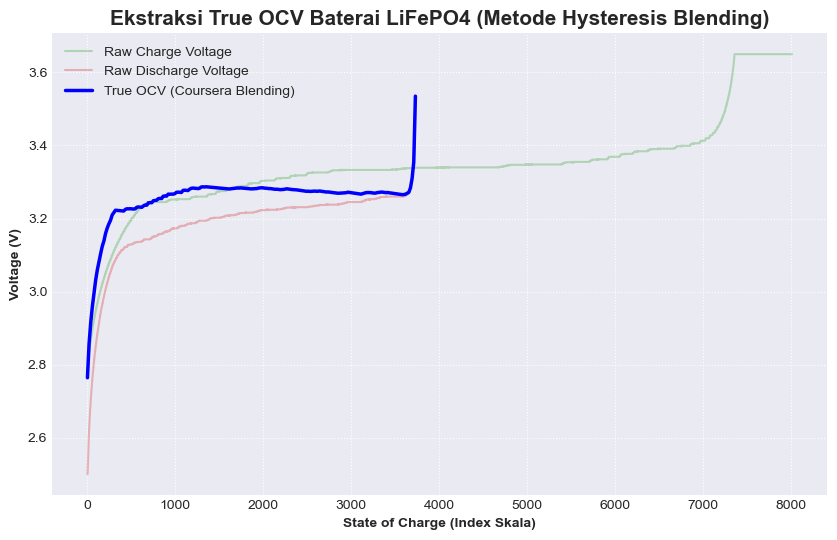

✅ File 'ocv_lookup_table.csv' berhasil disimpan untuk digunakan oleh EKF!


In [3]:
# Identifikasi blok Discharge dan Charge berdasarkan arus
# D-CC biasanya sekitar 10A, C-CV dimulai dari 5A turun ke 0.1A
df_raw['Mode_Det'] = 'Wait'
df_raw.loc[df_raw['Cur(A)'] > 9.0, 'Mode_Det'] = 'Discharge'
df_raw.loc[(df_raw['Cur(A)'] > 0.05) & (df_raw['Cur(A)'] <= 5.5), 'Mode_Det'] = 'Charge'

# Beri nomor urut pada setiap blok perubahan status
df_raw['Block'] = (df_raw['Mode_Det'] != df_raw['Mode_Det'].shift(1)).cumsum()

dis_blocks = df_raw[df_raw['Mode_Det'] == 'Discharge']['Block'].unique()
chg_blocks = df_raw[df_raw['Mode_Det'] == 'Charge']['Block'].unique()

# Kita ambil blok Discharge ke-2 dan Charge ke-2 agar datanya paling stabil
indD = df_raw[df_raw['Block'] == dis_blocks[1]].index.tolist()
indC = df_raw[df_raw['Block'] == chg_blocks[1]].index.tolist()

# -----------------------------------------------------------------
# IMPLEMENTASI ALGORITMA COURSERA (MATLAB -> PYTHON)
# -----------------------------------------------------------------
# 1. Hitung Voltage Drop (IR) di awal dan akhir
IR1Da = df_raw['Vol(V)'].iloc[indD[0]-1] - df_raw['Vol(V)'].iloc[indD[0]]
IR2Da = df_raw['Vol(V)'].iloc[indD[-1]+1] - df_raw['Vol(V)'].iloc[indD[-1]]

IR1Ca = df_raw['Vol(V)'].iloc[indC[0]] - df_raw['Vol(V)'].iloc[indC[0]-1]
IR2Ca = df_raw['Vol(V)'].iloc[indC[-1]] - df_raw['Vol(V)'].iloc[indC[-1]+1]

IR1D = min(IR1Da, 2 * IR2Ca); IR2D = min(IR2Da, 2 * IR1Ca)
IR1C = min(IR1Ca, 2 * IR2Da); IR2C = min(IR2Ca, 2 * IR1Da)

# 2. Blending Koreksi Kurva
blend_D = np.linspace(0, 1, len(indD))
IRblend_D = IR1D + (IR2D - IR1D) * blend_D
disV = df_raw['Vol(V)'].iloc[indD].values + IRblend_D
disZ = np.linspace(1, 0, len(indD)) # SoC turun

blend_C = np.linspace(0, 1, len(indC))
IRblend_C = IR1C + (IR2C - IR1C) * blend_C
chgV = df_raw['Vol(V)'].iloc[indC].values - IRblend_C
chgZ = np.linspace(0, 1, len(indC)) # SoC naik

# 3. Cari Titik Tengah (Hysteresis di SoC 50%)
f_chg = interp1d(chgZ, chgV, fill_value="extrapolate")
f_dis = interp1d(disZ, disV, fill_value="extrapolate")
deltaV50 = f_chg(0.5) - f_dis(0.5)

ind_chg_half = np.where(chgZ < 0.5)[0]
vChg = chgV[ind_chg_half] - (chgZ[ind_chg_half] * deltaV50)
zChg = chgZ[ind_chg_half]

ind_dis_half = np.where(disZ > 0.5)[0]
vDis = np.flip(disV[ind_dis_half] + ((1 - disZ[ind_dis_half]) * deltaV50))
zDis = np.flip(disZ[ind_dis_half])

# 4. Gabungkan dan Buat Lookup Table Final
z_combined = np.concatenate((zChg, zDis))
v_combined = np.concatenate((vChg, vDis))

sort_idx = np.argsort(z_combined)
z_combined = z_combined[sort_idx]
v_combined = v_combined[sort_idx]

# Output 200 titik SoC (0 sampai 100%)
SOC_out = np.linspace(0, 1, 200)
f_rawocv = interp1d(z_combined, v_combined, kind='linear', fill_value="extrapolate")
True_OCV = f_rawocv(SOC_out)

# -----------------------------------------------------------------
# VISUALISASI HASIL TRUE OCV
# -----------------------------------------------------------------
plt.figure(figsize=(10, 6))
plt.plot(df_raw['Vol(V)'].iloc[indC].values, color='tab:green', alpha=0.3, label='Raw Charge Voltage')
plt.plot(df_raw['Vol(V)'].iloc[indD].values[::-1], color='tab:red', alpha=0.3, label='Raw Discharge Voltage')

plt.plot(SOC_out * len(indD), True_OCV, 'b-', linewidth=2.5, label='True OCV (Coursera Blending)')
plt.title('Ekstraksi True OCV Baterai LiFePO4 (Metode Hysteresis Blending)', fontsize=15, fontweight='bold')
plt.xlabel('State of Charge (Index Skala)', fontweight='bold')
plt.ylabel('Voltage (V)', fontweight='bold')
plt.legend()
plt.grid(True, linestyle=':')
plt.show()

# Simpan Tabel OCV untuk dipakai di Algoritma EKF (Phase 3)
df_ocv_lookup = pd.DataFrame({'SoC': SOC_out, 'True_OCV': True_OCV})
df_ocv_lookup.to_csv('ocv_lookup_table.csv', index=False)
print("✅ File 'ocv_lookup_table.csv' berhasil disimpan untuk digunakan oleh EKF!")